In [88]:
from __future__ import division
import nltk
import re
import matplotlib.pyplot as plt
import numpy as np
from nltk.corpus import brown
from nltk import bigrams, ngrams, trigrams 
from nltk.probability import FreqDist as FreqDist  
from numpy.polynomial.polynomial import polyfit
from collections import Counter
from string import digits
from scipy import stats
import operator
from collections import OrderedDict

In [89]:
def get_sentences(num_sentences):
    sentences= brown.sents()[:num_sentences]
    ret=[]
    for sentence in sentences:
        ret.append(' '.join(sentence))
    return ret

In [90]:
def preprocess_sents(sentences):
    sentences = [sentence.lower() for sentence in sentences]
    remove_digits = str.maketrans('', '', digits)
    sentences = [sentence.translate(remove_digits)  for sentence in sentences]
    sentences=[re.sub('\W+',' ', sentence) for sentence in sentences]
    return sentences

In [104]:
def plot(x,y,Title=''):
    x=np.asarray(x)
    y=np.asarray(y)
    #slope, intercept=polyfit(x, y, 1)
    #plt.plot(x, intercept + slope*x, 'r', label='fitted line')
    plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)),'r', label='fitted line')
    plt.plot(x,y,label='original data')
    plt.title(Title)
    plt.legend()
    plt.show()

In [92]:
def unigram_LM(sents):
    unigrams=[]
    for elem in sents:
        unigrams.extend(elem.split())

    unigram_counts=Counter(unigrams)
    unique_unigrams=set(unigrams)
    unigram_total=len(unigrams)
    unigram_freq=dict()
    for word in unigram_counts:
        unigram_freq[word]=unigram_counts[word]/unigram_total

    unigram_counts['<s>']=len(sents)

    return unigram_counts,unigram_freq

In [93]:
def bigram_model(sentences,k=0,unique_bigrams_num=0):
    model={}
    for sent in sentences:
         for w1,w2 in ngrams(sent.split(),2, pad_left=True,pad_right=True,left_pad_symbol='<s>',right_pad_symbol='</s>'):
            if w1 not in model:
                model[w1]={}
            if w2 not in model[w1]:
                model[w1][w2]=0
            model[w1][w2]+=1
    for w1 in model:
        tot_count=float(sum(model[w1].values()))
        for w2 in model[w1]:
            model[w1][w2]+=k
            model[w1][w2]/=(tot_count+k*unique_bigrams_num)
     
    return model



In [94]:
def trigram_model(sentences=0,k=0,unique_trigrams_num=0):
    model={}
    for sent in sentences:
         for w1,w2,w3 in ngrams(sent.split(),3, pad_left=True,pad_right=True,left_pad_symbol='<s>',right_pad_symbol='</s>'):
            if (w1,w2) not in model:
                model[(w1,w2)]={}
            if w3 not in model[(w1,w2)]:
                model[(w1,w2)][w3]=0
            model[(w1,w2)][w3]+=1
    for (w1,w2) in model:
        tot_count=float(sum(model[(w1,w2)].values()))
        for w3 in model[(w1,w2)]:
            model[(w1,w2)][w3]+=k
            model[(w1,w2)][w3]/=(tot_count+k*unique_trigrams_num)
     
    return model


In [95]:
def get_test_sentences(filename='test_examples.txt'):
    sents=list()
    with open(filename,'r') as f:
        for line in f:
            sents.append(line)
        f.close()
    return preprocess_sents(sents)

In [96]:
def laplacian_unigram_model(w1,unigram_counts,k,V):
    N=len(unigram_counts)
    return np.log( ( (k+unigram_counts.get(w1,0))/(k*V+N) )  )
def laplacian_bigram_model(w1,w2,bigram_counts,unigram_counts,k,V):
    return np.log( ( (k+bigram_counts.get((w1,w2),0))/(k*V+unigram_counts.get(w1,0)) )  )

def laplacian_trigram_model(w1,w2,w3,trigram_counts,bigram_counts,k,num_unique_trigrams):
    if(w1=='<s>' and w2=='<s>'):
        return np.log( ( (k+trigram_counts.get((w1,w2,w3),0))/(k*num_unique_trigrams+bigram_counts.get((w2,w3),0)) )  )
    return np.log( ( (k+trigram_counts.get((w1,w2,w3),0))/(k*V+bigram_counts.get((w1,w2),0)) )  )

### Getting the sentences from the Brown corpus

In [97]:
sents=get_sentences(40000)            # Get 40k sentences from the Brown corpus as mentioned in assignment
sents=preprocess_sents(sents)

In [98]:
for sent in sents[:10]:
    print(sent)

the fulton county grand jury said friday an investigation of atlanta s recent primary election produced no evidence that any irregularities took place 
the jury further said in term end presentments that the city executive committee which had over all charge of the election deserves the praise and thanks of the city of atlanta for the manner in which the election was conducted 
the september october term jury had been charged by fulton superior court judge durwood pye to investigate reports of possible irregularities in the hard fought primary which was won by mayor nominate ivan allen jr 
 only a relative handful of such reports was received the jury said considering the widespread interest in the election the number of voters and the size of this city 
the jury said it did find that many of georgia s registration and election laws are outmoded or inadequate and often ambiguous 
it recommended that fulton legislators act to have these laws studied and revised to the end of modernizing

## Creating the Language Models

In [102]:
unigram_counts,unigram_freq=unigram_LM(sents)
bigram_LM= bigram_model(sents)
trigram_LM= trigram_model(sents)

## Verifying Zipf's Law

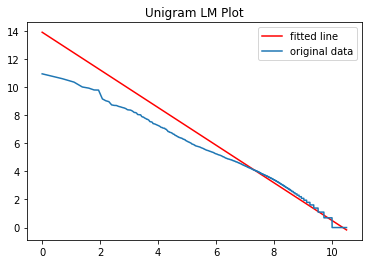

In [105]:
x=[np.log(i+1) for i in range(len(unigram_counts.most_common()))]
y=np.asarray(list(np.log(y[1]) for y in unigram_counts.most_common()))
plot(x,y,'Unigram LM Plot')
sorted_unigram_counts=sorted(unigram_counts.items(), key=operator.itemgetter(1),reverse=True)

In [106]:
bigram_counts={}
for sent in sents:
    for w in ngrams(sent.split(),2, pad_left=True,pad_right=True,left_pad_symbol='<s>',right_pad_symbol='</s>'):
        if(w not in bigram_counts):
            bigram_counts[w]=1
        else:
            bigram_counts[w]+=1


sorted_bigram_counts=sorted(bigram_counts.items(), key=operator.itemgetter(1),reverse=True)

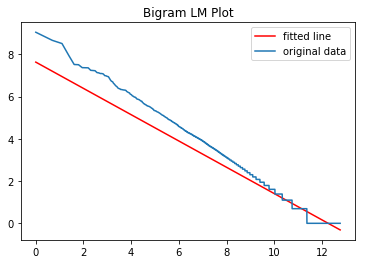

In [107]:
x=[np.log(i+1) for i in range(len(sorted_bigram_counts))]
y=np.asarray(list(np.log(y[1]) for y in sorted_bigram_counts[:]))
plot(x,y,'Bigram LM Plot')

In [108]:
trigram_counts={}
for sent in sents:
    for w in ngrams(sent.split(),3, pad_left=True,pad_right=True,left_pad_symbol='<s>',right_pad_symbol='</s>'):
        if(w not in trigram_counts):
            trigram_counts[w]=1
        else:
            trigram_counts[w]+=1



sorted_trigram_counts=sorted(trigram_counts.items(), key=operator.itemgetter(1),reverse=True)

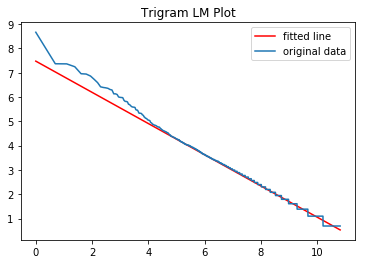

In [115]:
x=[np.log(i+1) for i in range(len(sorted_trigram_counts[:50000]))]
y=np.asarray(list(np.log(y[1]) for y in sorted_trigram_counts[:50000]))
plot(x,y,'Trigram LM Plot')

In [59]:
sorted_unigram_counts[:11]

[('the', 56474),
 ('<s>', 40000),
 ('of', 31329),
 ('and', 22154),
 ('to', 20413),
 ('a', 17918),
 ('in', 17766),
 ('is', 9474),
 ('that', 8306),
 ('for', 7797),
 ('it', 6198)]

In [53]:
sorted_bigram_counts[:10]

[(('of', 'the'), 8512),
 (('<s>', 'the'), 5798),
 (('in', 'the'), 4986),
 (('to', 'the'), 2820),
 (('and', 'the'), 1848),
 (('on', 'the'), 1829),
 (('for', 'the'), 1592),
 (('<s>', 'in'), 1585),
 (('<s>', 'it'), 1578),
 (('<s>', 'he'), 1403)]

In [56]:
sorted_trigram_counts[:10]

[(('<s>', '<s>', 'the'), 5798),
 (('<s>', '<s>', 'in'), 1585),
 (('<s>', '<s>', 'it'), 1578),
 (('<s>', '<s>', 'he'), 1403),
 (('<s>', '<s>', 'this'), 1052),
 (('<s>', '<s>', 'but'), 1038),
 (('<s>', '<s>', 'a'), 956),
 (('<s>', '<s>', 'and'), 831),
 (('<s>', '<s>', 'i'), 729),
 (('<s>', '<s>', 'they'), 614)]

## Testing (without smoothing)

In [45]:
test_sents=get_test_sentences()

In [46]:
test_unigram_arr=[]
print('Unigram test probabilities: ')
print()
for sent in test_sents:
    try:
        p_val=np.sum([np.log(unigram_freq[word]) for word in sent.split()])
    except Exception as e:
        p_val=-np.inf
    test_unigram_arr.append(p_val)
    print('The sequence \"'+sent+' \" has unigram probablity of '+ str(p_val))


Unigram test probabilities: 

The sequence "he lived a good life  " has unigram probablity of -32.61637181331728
The sequence "the man was happy  " has unigram probablity of -23.897270970344053
The sequence "the person was good  " has unigram probablity of -23.326684213898012
The sequence "the girl was sad  " has unigram probablity of -27.222336320670067
The sequence "he won the war " has unigram probablity of -24.106951714822433


In [47]:
test_bigram_arr=[]
for sent in test_sents:
    p_val=0
    for w1,w2 in bigrams(sent.split(),pad_left=True,pad_right=True,left_pad_symbol='<s>',right_pad_symbol='</s>'):
        if w1 in bigram_LM:
            try:
                p_val+=np.log(bigram_LM[w1][w2])
            except Exception as e:
                p_val=-np.inf
                break
        else:
            p_val=-np.inf
            break
    print('The sequence \"'+ sent +'\" has bigram probablity of '+ str(p_val))
    test_bigram_arr.append(p_val)

The sequence "he lived a good life " has bigram probablity of -26.88656843222555
The sequence "the man was happy " has bigram probablity of -22.06160121911623
The sequence "the person was good " has bigram probablity of -24.839981504247724
The sequence "the girl was sad " has bigram probablity of -inf
The sequence "he won the war" has bigram probablity of -20.079546963054263


In [48]:
test_trigram_arr=[]
print('Trigram test probabilities: ')
for sent in test_sents:
    p_val=0
    for w1,w2,w3 in trigrams(sent.split(),pad_left=True,pad_right=True,left_pad_symbol='<s>',right_pad_symbol='</s>'):
        try:
            p_val+=np.log(trigram_LM[(w1,w2)][w3])
        except Exception as e:
            p_val=-np.inf
            break
    print('The sequence \"'+ sent +'\" has trigram probablity of '+ str(p_val))
    
    test_trigram_arr.append(p_val)

Trigram test probabilities: 
The sequence "he lived a good life " has trigram probablity of -inf
The sequence "the man was happy " has trigram probablity of -inf
The sequence "the person was good " has trigram probablity of -inf
The sequence "the girl was sad " has trigram probablity of -inf
The sequence "he won the war" has trigram probablity of -16.519106408717104


## Laplace/ Additive Smoothing

In [49]:
k_list=[pow(10,i) for i in range(-4,1)]

In [51]:
test_uniigram_arr=[]
for k in k_list:
    print('Unigram test probabilities with Laplacian/ Additive Smoothing with k as',k,': \n')
    for sent in test_sents:
        p_val=0
        for w1 in sent.split():
            p_val+=laplacian_unigram_model(w1,unigram_counts,k,V)
        print('The sequence \"'+ sent +'\" has unigram probablity of '+ str(p_val))
        test_unigram_arr.append(p_val)
    print("\n")
    

Unigram test probabilities with Laplacian/ Additive Smoothing with k as 0.0001 : 

The sequence "he lived a good life " has unigram probablity of -17.278728667128117
The sequence "the man was happy " has unigram probablity of -11.62715614682182
The sequence "the person was good " has unigram probablity of -11.0565703479828
The sequence "the girl was sad " has unigram probablity of -14.952216470356795
The sequence "he won the war" has unigram probablity of -11.836837534506543


Unigram test probabilities with Laplacian/ Additive Smoothing with k as 0.001 : 

The sequence "he lived a good life " has unigram probablity of -17.283208670887742
The sequence "the man was happy " has unigram probablity of -11.630737390733085
The sequence "the person was good " has unigram probablity of -11.060160210247664
The sequence "the girl was sad " has unigram probablity of -14.955752474615409
The sequence "he won the war" has unigram probablity of -11.840424567185226


Unigram test probabilities with La

In [52]:
test_bigram_arr=[]
V=len(unigram_counts.values())
for k in k_list:

    print('Bigram test probabilities with Laplacian/ Additive Smoothing with k as',k,': ')
    for sent in test_sents:
        p_val=0
        for w1,w2 in bigrams(sent.split(),pad_left=True,pad_right=True,left_pad_symbol='<s>',right_pad_symbol='</s>'):
            p_val+=laplacian_bigram_model(w1,w2,bigram_counts,unigram_counts,k,V)

        print('The sequence \"'+ sent +'\" has bigram probablity of '+ str(p_val))
        test_bigram_arr.append(p_val)
    print("\n")

Bigram test probabilities with Laplacian/ Additive Smoothing with k as 0.0001 : 
The sequence "he lived a good life " has bigram probablity of -26.956115844462982
The sequence "the man was happy " has bigram probablity of -22.128016928486232
The sequence "the person was good " has bigram probablity of -24.87279365929685
The sequence "the girl was sad " has bigram probablity of -34.43170756838363
The sequence "he won the war" has bigram probablity of -20.123700434271637


Bigram test probabilities with Laplacian/ Additive Smoothing with k as 0.001 : 
The sequence "he lived a good life " has bigram probablity of -27.471899994710714
The sequence "the man was happy " has bigram probablity of -22.601935867047906
The sequence "the person was good " has bigram probablity of -25.13996877695201
The sequence "the girl was sad " has bigram probablity of -33.362882449445124
The sequence "he won the war" has bigram probablity of -20.472866918268032


Bigram test probabilities with Laplacian/ Additi

In [24]:
for k in k_list:
    test_trigram_arr=[]
    print('Trigram test probabilities with Laplacian/ Additive Smoothing with k as',k,': \n')
    for sent in test_sents:
        p_val=0
        for w1,w2,w3 in trigrams(sent.split(),pad_left=True,pad_right=True,left_pad_symbol='<s>',right_pad_symbol='</s>'):
            p_val+=laplacian_trigram_model(w1,w2,w3,trigram_counts,bigram_counts,k,V)
        print('The sequence \"'+ sent +'\" has trigram probablity of '+ str(p_val))

        test_trigram_arr.append(p_val)
    print("\n")

Trigram test probabilities with Laplacian/ Additive Smoothing with k as 0.0001 : 

The sequence "he lived a good life " has trigram probablity of -44.35954307238338
The sequence "the man was happy " has trigram probablity of -32.525849932687606
The sequence "the person was good " has trigram probablity of -32.81651234922698
The sequence "the girl was sad " has trigram probablity of -34.03222847979623
The sequence "he won the war" has trigram probablity of -13.873468626625245


Trigram test probabilities with Laplacian/ Additive Smoothing with k as 0.001 : 

The sequence "he lived a good life " has trigram probablity of -43.56698735123187
The sequence "the man was happy " has trigram probablity of -32.45567022859919
The sequence "the person was good " has trigram probablity of -33.413265167818885
The sequence "the girl was sad " has trigram probablity of -36.63228918957997
The sequence "he won the war" has trigram probablity of -16.980838422854518


Trigram test probabilities with Lapla

## Interpolation Models

In [25]:
def interpolation_bigram(w1,w2,Lambda,bigram_counts,unigram_counts):
    num_unigrams=len(unigram_counts.values())
    if (w1 in unigram_counts):
        probability= Lambda*((bigram_counts.get((w1,w2),0))/(unigram_counts.get(w1,0))) +(1-Lambda)*(unigram_counts.get(w2,0)/num_unigrams)
    else:
        print(w1)
        return -np.inf
    if(probability==0):
        return -np.inf
    else:
        return np.log(probability)

In [26]:
test_bigram_arr=[]
lambda_list=[0.2, 0.5, 0.8]
num_unique_bigrams=len(bigram_counts.values())
for Lambda in lambda_list:

    print('Bigram test probabilities with Interpolation with lambda as',Lambda,': ')
    for sent in test_sents:
        p_val=0
        for w1,w2 in bigrams(sent.split(),pad_left=True,pad_right=True,left_pad_symbol='<s>',right_pad_symbol='</s>'):
            p_val+=interpolation_bigram(w1,w2,Lambda,bigram_counts,unigram_counts)

        print('The sequence \"'+ sent +'\" has bigram probablity of '+ str(p_val))
        test_bigram_arr.append(p_val)
    print("\n")

Bigram test probabilities with Interpolation with lambda as 0.2 : 
The sequence "he lived a good life " has bigram probablity of -21.22206613167789
The sequence "the man was happy " has bigram probablity of -16.0985514676804
The sequence "the person was good " has bigram probablity of -16.218514874415803
The sequence "the girl was sad " has bigram probablity of -19.51848178080951
The sequence "he won the war" has bigram probablity of -15.807276922168901


Bigram test probabilities with Interpolation with lambda as 0.5 : 
The sequence "he lived a good life " has bigram probablity of -21.70829104486406
The sequence "the man was happy " has bigram probablity of -16.666814503643206
The sequence "the person was good " has bigram probablity of -16.98712336693744
The sequence "the girl was sad " has bigram probablity of -20.266873101374973
The sequence "he won the war" has bigram probablity of -16.151138693025025


Bigram test probabilities with Interpolation with lambda as 0.8 : 
The sequenc

In [114]:
len(sorted_trigram_counts)

654361

In [116]:
len(sorted_bigram_counts)

349144